# Building a Bayesian Network
**David S. Fulford**  
*January, 2019*

Bayesian networks are useful tools for prediction/imputing values of missing or hidden/latent variables. These problems arise frequently in data analysis where samples may be missing certain variables, or certain variables are measured from sensors that display an inordinate amount of noise.

The [Monty Hall Problem](https://en.wikipedia.org/wiki/Monty_Hall_problem) is a simple problem in which we desire to choose one of three doors that contains a prize. The only information we have is that the door containing the prize is completely random&mdash;that is, it is equally likely to be behind either of the three doors&mdash; and Monty will choose a door that is not the door the guest has chosen, or the door with the prize behind.

From this information, we must then choose which door to open. The game is framed to the player as "would you like to switch doors?" to take advantage of the [endowment effect](https://en.wikipedia.org/wiki/Endowment_effect). As we'll see, it is ***always*** better to switch, while the game frames the player to desire to never switch. It's important to understand the prior probabilties, and how the information gain changes those probabilities, to act against our desire to stick with our original choice.

In [1]:
import numpy as np
import pomegranate as pg

import daft
import matplotlib as mpl
from matplotlib import pyplot as plt

#### Import the libraries we'll be using.

* [Numpy](http://www.numpy.org/) is one of the fundamental packages for Python that provides access to powerful functions for working with arrays.
* [Pomegranate](https://pomegranate.readthedocs.io/en/latest/index.html) is the only library we need to run the Bayesian Network.
* [Daft](http://daft-pgm.org/) is a library used to render graphical models that does not require installation of any additional software. Although Pomegranata can render its networks using GraphViz, GraphViz and PyGraphViz must exist on the system, and the installation on Windows is not well supported.
* [Matplotlib](https://matplotlib.org/) is our standard plotting package, and is used by Daft in this example.

We'll display the network first.

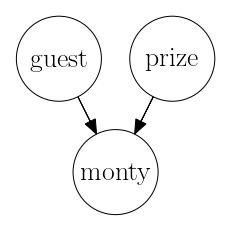

In [2]:
import daft
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 28
mpl.rcParams['text.usetex'] = True

scale = 3
# Instantiate the PGM.
pgm = daft.PGM()

# Hierarchical parameters.
pgm.add_node('s1', 'guest', 1, 0, scale)
pgm.add_node('s2', 'prize', 3, 0, scale)
pgm.add_node('s3', 'monty', 2, -2, scale)

# Add in the edges.
arrow={'head_width':.4, 'head_length':.5}
pgm.add_edge('s1', 's3', plot_params=arrow)
pgm.add_edge('s2', 's3', plot_params=arrow)

# Render.
pgm.show()

The door the guest chooses, and the door hiding the prize, are not dependent on any other variable. We'll assume a uniform distribution for each (1/3 chance of each of the three doors).

The choice by Monty is a dependent upon both the guest's choice and the prize door, so we construct a conditional probability table.

The visualization of the graph tells us how information flows in the network. For example, until we know what door Monty has chosen, we do not have any information to relate `guest` to `prize`. We say that these variables are ***conditionally indepedent***. Both are represented by uniform distributions.

Once we have observed `monty`, *then* the path between `guest` and `prize` is active through `monty` &mdash; `guest` and `prize` are no longer independent. Then, given that we only know `guest` and `monty` we could make a posterior prediction for `prize`. The network influence would flow like this:

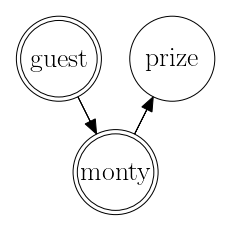

In [3]:
pgm = daft.PGM(observed_style='inner')
pgm.add_node('s1', 'guest', 1, 0, scale, observed=True); pgm.add_node('s2', 'prize', 3, 0, scale); \
    pgm.add_node('s3', 'monty', 2, -2, scale, observed=True)
pgm.add_edge('s1', 's3', plot_params=arrow); pgm.add_edge('s3', 's2', plot_params=arrow)
pgm.show()

First, we build the network.
 - `guest` has a conditionally indepedent uniform distribution
 - `prize` has a conditionally indepedent uniform distribution
 - `monty` has a conditional distribution defined by the rules of the game (Monty will open a door that is not chosen by the guest and does not have the prize behind it)
 
 We define distributions for the conditionally independent variables:

In [4]:
# Define Distributions
guest = pg.DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})
prize = pg.DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})

Now, we build the conditional probability table based upon the rules of the game:

In [5]:
doors = ['A', 'B', 'C']
m_count = []
for g in doors:
    for p in doors:
        t_count = 0
        # Loop through and count total possible outcomes for P(monty | guest, prize)
        for m in doors:
            if m != g and m != p:
                # Monty can pick a door not picked by guest and not hiding a prize
                t_count += 1
        # Loop through and calculate conditional probability P(monty | guest, prize)
        for m in doors:
            if m != g and m != p:
                # Monty can pick a door not picked by guest and not hiding a prize
                m_count.append([g, p, m, 1. / t_count])
            else:
                m_count.append([g, p, m, 0.])

monty = pg.ConditionalProbabilityTable(
        m_count, [guest, prize])

m_count

[['A', 'A', 'A', 0.0],
 ['A', 'A', 'B', 0.5],
 ['A', 'A', 'C', 0.5],
 ['A', 'B', 'A', 0.0],
 ['A', 'B', 'B', 0.0],
 ['A', 'B', 'C', 1.0],
 ['A', 'C', 'A', 0.0],
 ['A', 'C', 'B', 1.0],
 ['A', 'C', 'C', 0.0],
 ['B', 'A', 'A', 0.0],
 ['B', 'A', 'B', 0.0],
 ['B', 'A', 'C', 1.0],
 ['B', 'B', 'A', 0.5],
 ['B', 'B', 'B', 0.0],
 ['B', 'B', 'C', 0.5],
 ['B', 'C', 'A', 1.0],
 ['B', 'C', 'B', 0.0],
 ['B', 'C', 'C', 0.0],
 ['C', 'A', 'A', 0.0],
 ['C', 'A', 'B', 1.0],
 ['C', 'A', 'C', 0.0],
 ['C', 'B', 'A', 1.0],
 ['C', 'B', 'B', 0.0],
 ['C', 'B', 'C', 0.0],
 ['C', 'C', 'A', 0.5],
 ['C', 'C', 'B', 0.5],
 ['C', 'C', 'C', 0.0]]

In [6]:
# Initialize model
model = pg.BayesianNetwork('Monty Hall Problem')

# Define nodes
s1 = pg.Node(guest, name='guest')
s2 = pg.Node(prize, name='prize')
s3 = pg.Node(monty, name='monty')

# Add edges
model.add_states(s1, s2, s3)
model.add_edge(s1, s3)
model.add_edge(s2, s3)

# Build model
model.bake()

#### Marginal Probabilties
We can evaluate the marginal probability of Monty's choice given the guest and prize variables First, let's verify we have a proper prior marginal for Monty's choice computed from our conditional probability table:

In [7]:
model.marginal()[2].parameters

[{'B': 0.3333333333333333, 'C': 0.3333333333333333, 'A': 0.3333333333333333}]

Which is correct!

Now, show the marginal probability of specific outcomes:

In [8]:
# Either a single array, or a matrix
print('Trying as array:')
try:
    display(model.probability(['A', 'A', 'B']))
    print('\t Success!!!' '\n' '\t Passed as array')
except:
    print('\t Error!!!' '\n' '\t Must always pass a matrix')

print('\n\n' 'Trying as matrix:')
print(model.probability([['A', 'A', 'B'],
                         ['A', 'A', 'B'],
                         ['A', 'A', 'C'],
                         ['C', 'C', 'B']])
     )

Trying as array:


0.05555555555555554

	 Success!!!
	 Passed as array


Trying as matrix:
[0.05555556 0.05555556 0.05555556 0.05555556]


#### Prediction
We're more interested in the prediction given a missing variable, however. Here we can make a prediction for the door Monty will pick given a door chosen by the guest, and the door hiding the prize.

In [9]:
# Must always be a matrix
print('Trying as array:')
try:
    display(model.predict(['A', 'B', None]))
    print('\t Success!!!' '\n' '\t Passed as array')
except:
    print('\t Error!!!' '\n' '\t Must always pass a matrix')

print('\n\n' 'Tring as matrix:')
display(model.predict([['A', 'B', None],
                       ['A', 'C', None],
                       ['B', 'A', None],
                       ['B', 'C', None],
                       ['C', 'A', None],
                       ['C', 'B', None]])
     )

Trying as array:
	 Error!!!
	 Must always pass a matrix


Tring as matrix:


[array(['A', 'B', 'C'], dtype=object),
 array(['A', 'C', 'B'], dtype=object),
 array(['B', 'A', 'C'], dtype=object),
 array(['B', 'C', 'A'], dtype=object),
 array(['C', 'A', 'B'], dtype=object),
 array(['C', 'B', 'A'], dtype=object)]

#### Should we switch doors?

In the case of the Monty Hall problem, we want to predict the door containing the prize *given* our first choice, and Monty's choice, as we do not know which door is hiding the prize. This is the Bayesian problem, where we desired to ***invert*** our graph:

In [10]:
# Must always be a matrix
display(model.predict([['A', None, 'B'],
                       ['A', None, 'C'],
                       ['B', None, 'A'],
                       ['B', None, 'C'],
                       ['C', None, 'A'],
                       ['C', None, 'B']])
     )

[array(['A', 'C', 'B'], dtype=object),
 array(['A', 'B', 'C'], dtype=object),
 array(['B', 'C', 'A'], dtype=object),
 array(['B', 'A', 'C'], dtype=object),
 array(['C', 'B', 'A'], dtype=object),
 array(['C', 'A', 'B'], dtype=object)]

The interpretation of the predictions is that it is *always* better to switch the door once Monty makes his choice! We can also look at the probabilities of each value as opposed to just the prediction. This is known as ***marginalization***, in which we "marginalize out" the observed variables. Mathematically, we sum (or integrate) the outcomes from our conditional probability table for the unobserved variables *over* the subset of outcomes which match the observed variables.

In [11]:
print('Show Probabilities for each door:')
display(model.predict_proba({'guest':'A', 'monty':'B'})[1].parameters)

print('\n Where the maximum likelihood matches the prediction:')
display(model.predict([['A', None, 'B']])[0][1])

Show Probabilities for each door:


[{'A': 0.3333333333333334, 'B': 0.0, 'C': 0.6666666666666664}]


 Where the maximum likelihood matches the prediction:


'C'

### Example Game

Let's show an example of the game. The Guest chooses door 1, while door 2 has the prize. We know that:
- There is a 33.3% chance the prize is behind the door chosen.
- There is a 66.6% chance the prize is behind a door not chosen.

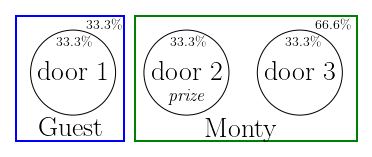

In [12]:
pgm = daft.PGM()
pgm.add_node('d1', 'door 1', 1, 1, scale); pgm.add_node('d2', 'door 2', 3, 1, scale); pgm.add_node('d3', 'door 3', 5, 1, scale)
pgm.add_plate([0, 0, 1.9, 2], label='Guest', shift=-0.2, label_offset=[22.5, 5], rect_params={'lw':2, 'ec':'b'})
pgm.add_plate([2.1, 0, 3.9, 2], label='Monty', shift=-0.2, label_offset=[22.5*2+25, 5], rect_params={'lw':2, 'ec':'g'})
pgm.add_plate([2.1, 0, 3.9, 2], label=r'\it prize', shift=-0.2, label_offset=[32.5, 40], fontsize=18, rect_params={'ec':None})
pgm.add_plate([0, 0, 1.9, 2], label='33.3\%', shift=-0.2, label_offset=[40, 95], fontsize=14, rect_params={'ec':None})
pgm.add_plate([0, 0, 1.9, 2], label='33.3\%', shift=-0.2, label_offset=[70, 112], fontsize=14, rect_params={'ec':None})
pgm.add_plate([2.1, 0, 3.9, 2], label='33.3\%', shift=-0.2, label_offset=[35, 95], fontsize=14, rect_params={'ec':None})
pgm.add_plate([2.1, 0, 3.9, 2], label='33.3\%', shift=-0.2, label_offset=[150, 95], fontsize=14, rect_params={'ec':None})
pgm.add_plate([2.1, 0, 3.9, 2], label='66.6\%', shift=-0.2, label_offset=[180, 112], fontsize=14, rect_params={'ec':None})
pgm.show()

Based upon the rules of the game, Monty **must** choose door 3 and reveal no prize behind it. 

- There is still a 33.3% chance the prize is behind the door chosen.
- There is still a 66.6% chance the prize is behind a door not chosen.

However, because Monty's choice is not random&mdash; he cannot choose the door with a prize behind it&mdash; we can exploit our knowledge and conclude that door 2 must inherit the probability from door 3.

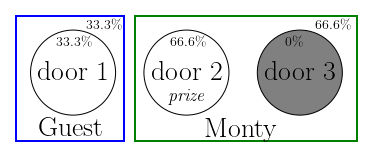

In [13]:
pgm = daft.PGM()
pgm.add_node('d1', 'door 1', 1, 1, scale); pgm.add_node('d2', r'door 2', 3, 1, scale); pgm.add_node('d3', 'door 3', 5, 1, scale, plot_params={'fc':'grey'})
pgm.add_plate([0, 0, 1.9, 2], label='Guest', shift=-0.2, label_offset=[22.5, 5], rect_params={'lw':2, 'ec':'b'})
pgm.add_plate([2.1, 0, 3.9, 2], label='Monty', shift=-0.2, label_offset=[22.5*2+25, 5], rect_params={'lw':2, 'ec':'g'})
pgm.add_plate([2.1, 0, 3.9, 2], label=r'\it prize', shift=-0.2, label_offset=[32.5, 40], fontsize=18, rect_params={'ec':None})
pgm.add_plate([0, 0, 1.9, 2], label='33.3\%', shift=-0.2, label_offset=[40, 95], fontsize=14, rect_params={'ec':None})
pgm.add_plate([0, 0, 1.9, 2], label='33.3\%', shift=-0.2, label_offset=[70, 112], fontsize=14, rect_params={'ec':None})
pgm.add_plate([2.1, 0, 3.9, 2], label='66.6\%', shift=-0.2, label_offset=[35, 95], fontsize=14, rect_params={'ec':None})
pgm.add_plate([2.1, 0, 3.9, 2], label='0\%', shift=-0.2, label_offset=[150, 95], fontsize=14, rect_params={'ec':None})
pgm.add_plate([2.1, 0, 3.9, 2], label='66.6\%', shift=-0.2, label_offset=[180, 112], fontsize=14, rect_params={'ec':None})
pgm.show()

And to use our Bayesian Network: 

In [14]:
display(model.predict_proba({'guest': 'A', 'monty':'C'})[1].parameters)

[{'A': 0.3333333333333334, 'B': 0.6666666666666664, 'C': 0.0}]

We can easily compute the posterior probability, and use the maximum likelihood to make a prediction.

Bayesian Networks allow us to encode known rules, logic, and relations into a system, and provides us with a prediction that incorporates all available information!